In [3]:
import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults
from scipy import stats
import seaborn as sns

In [4]:
df_shoot = pd.read_csv("shootings.csv", index_col = 0)

# Make index numbers start from 1
df_shoot.index = np.arange(1, len(df_shoot) + 1)

# Grouping all weapon object categories into one
def assign_arms(arms):
    if arms != 'Unarmed':
        arms = 'Armed'
    return arms
df_shoot.loc[:, 'arms_category'] = df_shoot.arms_category.apply(assign_arms)

# Change race group names
def assign_race(race):
    if race == 'White':
        race = 'Caucasian'
    if race == 'Native':
        race = 'Native-American'
    if race == 'Black':
        race = 'African-American'
    return race
df_shoot.loc[:, 'race'] = df_shoot.race.apply(assign_race)

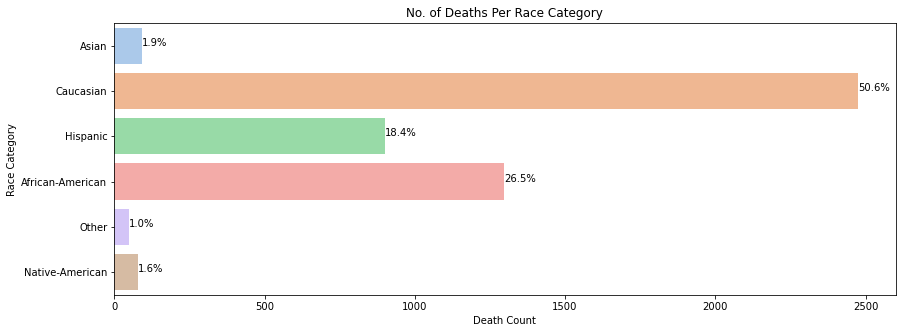

In [5]:
# No. of deaths per race
plt.figure(figsize = (14, 5))
plt.title("No. of Deaths Per Race Category")

ax = sns.countplot(y = "race", palette = "pastel", data = df_shoot)
ax.set(xlabel = 'Death Count', ylabel = 'Race Category')

total = len(df_shoot['race'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y));

Since Asian, Native-American and Other categories account for far less death counts individually, we group them into "Other".

In [6]:
def combine_other(race):
    if race == 'Asian' or race == 'Native-American':
        race = 'Other'
    return race
df_shoot.loc[:, 'race'] = df_shoot.race.apply(combine_other)

# One-way Anova

RQ 1.1 - Find out if there are differences in mean death counts between race categories. <br>
H0: There is no difference in mean death count between race categories. <br>
Ha: There is a difference in mean death count between race categories.

In [78]:
# Preparing data for ANOVA
df_shoot['date'] = pd.to_datetime(df_shoot['date'])

df_race = df_shoot.groupby([df_shoot.date.dt.year, 'race']).count()['name'].reset_index(level = 1)
df_race.columns = ['Race', 'Count']
df_race = df_race.drop(['2020'], axis = 'index')
df_race

,Race,Count
date,,
2015,African-American,258
2015,Caucasian,497
2015,Hispanic,172
2015,Other,38
2016,African-American,234
2016,Caucasian,468
2016,Hispanic,160
2016,Other,42
2017,African-American,224


In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# pd.options.display.float_format = '{:.3f}'.format

model = ols('Count ~ C(Race)', data = df_race).fit()
aov_table = sm.stats.anova_lm(model)

In [9]:
# Summary of linear regression
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     430.5
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           1.67e-15
Time:                        12:55:27   Log-Likelihood:                -84.777
No. Observations:                  20   AIC:                             177.6
Df Residuals:                      16   BIC:                             181.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              239.0000      8.387     28.495      0.000     221.219     256.781
C(Race)[T.Caucasian]   217.4000     11.862     18.328      0.000     192.254     242.546
C(Race)[T.Hispanic]    -71.2000     11.862     -6.003      0.000     -96.346     -46.054
C(Race)[T.Other]      -198.0000     11.862    -16.692      0.000    -223.146    -172.854
==============================================================================
Omnibus:                       10.745   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.861
Skew:                          -0.750   Prob(JB):                      0.00161
Kurtosis:                       6.631   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Anova table
display(aov_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(Race),3.0,454326.95,151442.316667,430.539635,1.668334e-15
Residual,16.0,5628.00,351.750000,NaN,NaN


In [11]:
# Effect size (Omega Squared) calculation for one way Anova
def effect_size(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

effect_size_df = effect_size(aov_table)
effect_size_df

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Race),454326.95,3.0,151442.316667,430.539635,1.668334e-15,0.987764,0.984717
Residual,5628.00,16.0,351.750000,NaN,NaN,NaN,NaN


Thus, we can say that there is a significant difference in mean death counts among different race categories, F = 430.5, p-value = 1.668334e-15, with an overall large effect, $ω^{2}$ = 0.98. <br>
In order to tell which groups differed significantly, we will conduct a post-hoc test using Tukey's HSD.

In [46]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_race['Count'], df_race['Race'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
African-American,Caucasian,217.4,0.001,183.4608,251.3392,True
African-American,Hispanic,-71.2,0.001,-105.1392,-37.2608,True
African-American,Other,-198.0,0.001,-231.9392,-164.0608,True
Caucasian,Hispanic,-288.6,0.001,-322.5392,-254.6608,True
Caucasian,Other,-415.4,0.001,-449.3392,-381.4608,True
Hispanic,Other,-126.8,0.001,-160.7392,-92.8608,True


Using Tukey HSD to test for differences between groups indicates that there is a statistically significant difference in death counts between all race categories.

# Two Way Anova 

RQ 1.2 - <br>
We will check whether the death of a person who was shot by police is influenced by : <br> 
- The person's race and, <br>
- Whether they were armed or not at the time of shooting. <br>

H0: There is no difference in average death counts between race categories. <br>
Ha: There is a difference in average death counts between race categories. <br>

H0: There is no difference in average death counts when the person was armed or unarmed. <br>
H1: There is a difference in average death counts when the person was armed or unarmed.  <br>

H0: The effect of race categories on average death count does not depend on whether the person was armed. (No interaction) <br>
H1: The effect of race categories on average death count depends on whether the person was armed. (Significant interaction)

In [34]:
# Preparing data for 2 Way ANOVA
df_race1 = df_shoot[['date','race', 'arms_category', 'name']]
df_race1 = df_race1.groupby([df_race1.date.dt.year, 'race', 'arms_category']).count()['name'].reset_index(level = [0, 1, 2])
df_race1.columns = ['Year', 'Race', 'Arms_Category', 'Count']

#Dropping data of Year 2020 because it is incomplete
index_names = df_race1[df_race1['Year'] == 2020].index
df_race1.drop(index_names, inplace = True)
df_race1

,Year,Race,Arms_Category,Count
0,2015,African-American,Armed,220
1,2015,African-American,Unarmed,38
2,2015,Caucasian,Armed,465
3,2015,Caucasian,Unarmed,32
4,2015,Hispanic,Armed,153
5,2015,Hispanic,Unarmed,19
6,2015,Other,Armed,33
7,2015,Other,Unarmed,5
8,2016,African-American,Armed,215
9,2016,African-American,Unarmed,19


In [35]:
model1 = ols('Count ~ C(Race) + C(Arms_Category) + C(Race):C(Arms_Category)', data = df_race1).fit()
aov_table1 = sm.stats.anova_lm(model1)

In [36]:
# Summary of regression
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     649.6
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           1.27e-32
Time:                        17:13:50   Log-Likelihood:                -155.18
No. Observations:                  40   AIC:                             326.4
Df Residuals:                      32   BIC:                             339.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          215.8000      5.855     36.855      0.000     203.873     227.727
C(Race)[T.Caucasian]                               213.6000      8.281     25.795      0.000     196.733     230.467
C(Race)[T.Hispanic]                                -60.0000      8.281     -7.246      0.000     -76.867     -43.133
C(Race)[T.Other]                                  -177.8000      8.281    -21.472      0.000    -194.667    -160.933
C(Arms_Category)[T.Unarmed]                       -192.6000      8.281    -23.259      0.000    -209.467    -175.733
C(Race)[T.Caucasian]:C(Arms_Category)[T.Unarmed]  -209.8000     11.711    -17.915      0.000    -233.654    -185.946
C(Race)[T.Hispanic]:C(Arms_Category)[T.Unarmed]     48.8000     11.711      4.167      0.000      24.946      72.654
C(Race)[T.Other]:C(Arms_Category)[T.Unarmed]       157.6000     11.711     13.458      0.000     133.746     181.454
==============================================================================
Omnibus:                       25.291   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.765
Skew:                          -1.091   Prob(JB):                     9.85e-27
Kurtosis:                      11.191   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# 2 way Anova table
display(aov_table1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Race),3.0,227163.475,75721.158333,441.715959,4.168485e-26
C(Arms_Category),1.0,374229.025,374229.025000,2183.048126,5.072413e-31
C(Race):C(Arms_Category),3.0,178080.875,59360.291667,346.275582,1.841551e-24
Residual,32.0,5485.600,171.425000,NaN,NaN


We see that the main effects are siginificant along with the interaction. We will have to look at the interaction plot to pinpoint specific differences.

In [57]:
effect_size_df1 = effect_size(aov_table1)
effect_size_df1

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Race),227163.475,3.0,75721.158333,441.715959,4.168485e-26,0.289395,0.288677
C(Arms_Category),374229.025,1.0,374229.025000,2183.048126,5.072413e-31,0.476750,0.476427
C(Race):C(Arms_Category),178080.875,3.0,59360.291667,346.275582,1.841551e-24,0.226866,0.226162
Residual,5485.600,32.0,171.425000,NaN,NaN,NaN,NaN


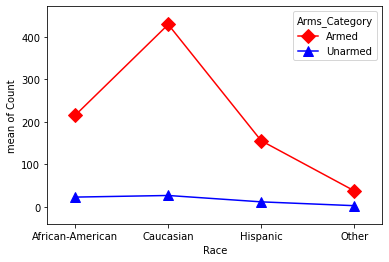

In [58]:
# Interaction plot
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(x = df_race1.Race, trace = df_race1.Arms_Category, response = df_race1.Count,
                       colors = ['red', 'blue'], markers = ['D', '^'], ms = 10);

The interaction plot suggests that : <br>
- Overall, death count accross all races have been similar when they do not posses a weapon in a shooting situation with the police.
- There is an insignificant difference in deaths when people of Other race category were armed or unarmed in a shooting situation; the number of people in the Other category who were armed and shot dead is marginally higher than those who were unarmed.
- The number of people who were armed and shot dead by the police is significantly higher for Caucasians, African-Americans and Hispanic.
- We reject the null hypothesis and say that there is an effect of race categories on average death counts depending on if the person was armed, F = 346.2, p-value = 1.841551e-24, with an effect, $ω^{2}$ = 0.22.
- However, there is no evidence that the police targets people of certain race on the basis whether they were armed or not and therefore, the data does not suggest racism by police.

RQ 1.3 - <br>
We will check whether the death of a person who was shot by police is influenced by : <br>
- The person's race and, <br>
- Whether the police was wearing an active body camera at the time of the shooting. <br>

H0: There is no difference in average death counts between race categories. <br>
Ha: There is a difference in average death counts between race categories. <br>

H0: There is no difference in average death counts based on whether the police was recording the incident using an active body camera. <br>
H1: There is a difference in average death counts based on whether the police was recording the incident using an active body camera. <br>

H0: The effect of race categories on average death count does not depend on whether the police was recording the incident using an active body camera. (No interaction) <br>
H1: The effect of race categories on average death count depends on whether the police was recording the incident using an active body camera. (Significant interaction) <br>

In [47]:
# Preparing data for 2 Way ANOVA
df_race2 = df_shoot[['date','race', 'body_camera', 'name']]
df_race2 = df_race2.groupby([df_race2.date.dt.year, 'race', 'body_camera']).count()['name'].reset_index(level = [0, 1, 2])
df_race2.columns = ['Year', 'Race', 'Body_Camera', 'Count']

#Dropping data of Year 2020 because it is incomplete
index_names = df_race2[df_race2['Year'] == 2020].index
df_race2.drop(index_names, inplace = True)
df_race2

,Year,Race,Body_Camera,Count
0,2015,African-American,False,235
1,2015,African-American,True,23
2,2015,Caucasian,False,461
3,2015,Caucasian,True,36
4,2015,Hispanic,False,158
5,2015,Hispanic,True,14
6,2015,Other,False,37
7,2015,Other,True,1
8,2016,African-American,False,195
9,2016,African-American,True,39


In [48]:
model2 = ols('Count ~ C(Race) + C(Body_Camera) + C(Race):C(Body_Camera)', data = df_race2).fit()
aov_table2 = sm.stats.anova_lm(model2)

In [52]:
# Summary of regression
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     384.1
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           5.19e-29
Time:                        23:43:32   Log-Likelihood:                -162.83
No. Observations:                  40   AIC:                             341.7
Df Residuals:                      32   BIC:                             355.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                     202.2000      7.090     28.519      0.000     187.758     216.642
C(Race)[T.Caucasian]                          209.8000     10.027     20.924      0.000     189.376     230.224
C(Race)[T.Hispanic]                           -54.6000     10.027     -5.445      0.000     -75.024     -34.176
C(Race)[T.Other]                             -167.8000     10.027    -16.735      0.000    -188.224    -147.376
C(Body_Camera)[T.True]                       -165.4000     10.027    -16.496      0.000    -185.824    -144.976
C(Race)[T.Caucasian]:C(Body_Camera)[T.True]  -202.2000     14.180    -14.259      0.000    -231.084    -173.316
C(Race)[T.Hispanic]:C(Body_Camera)[T.True]     38.0000     14.180      2.680      0.012       9.116      66.884
C(Race)[T.Other]:C(Body_Camera)[T.True]       137.6000     14.180      9.704      0.000     108.716     166.484
==============================================================================
Omnibus:                       13.067   Durbin-Watson:                   2.599
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.478
Skew:                           0.380   Prob(JB):                     2.68e-09
Kurtosis:                       7.807   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# 2 way Anova table
display(aov_table2)

,df,sum_sq,mean_sq,F,PR(>F)
C(Race),3.0,227163.475,75721.158333,301.257841,1.588731e-23
C(Body_Camera),1.0,296012.025,296012.025000,1177.688582,8.148359e-27
C(Race):C(Body_Camera),3.0,152714.275,50904.758333,202.525396,6.952407e-21
Residual,32.0,8043.200,251.350000,NaN,NaN


We see that the main effects are siginificant along with the interaction. We will have to look at the interaction plot to pinpoint specific differences.

In [59]:
effect_size_df2 = effect_size(aov_table2)
effect_size_df2

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Race),227163.475,3.0,75721.158333,301.257841,1.588731e-23,0.332143,0.330919
C(Body_Camera),296012.025,1.0,296012.025000,1177.688582,8.148359e-27,0.432809,0.432282
C(Race):C(Body_Camera),152714.275,3.0,50904.758333,202.525396,6.952407e-21,0.223288,0.222104
Residual,8043.200,32.0,251.350000,NaN,NaN,NaN,NaN


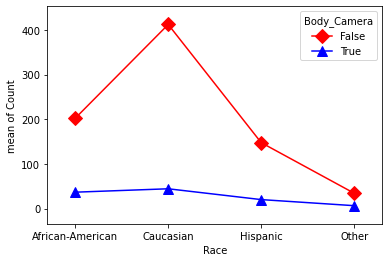

In [60]:
# Interaction plot

fig1 = interaction_plot(x = df_race2.Race, trace = df_race2.Body_Camera, response = df_race2.Count,
                       colors = ['red', 'blue'], markers = ['D', '^'], ms = 10);

The interaction plot suggests that : <br>
- Overall, death count accross all races have been similar when the police was not recording the incident using a body camera.
- Whether the police was recording the incident or not did not affect the death count significantly for people of Other race category involved in an encounter with the police.
- For the other three race categories, death counts by police were siginificantly higher when they were not wearing a body camera and recording the incident.
- We reject the null hypothesis and say that there is an effect of race categories on average death counts depending on if the police was recording the incident, F = 202.2, p-value = 6.952407e-21, with an effect, $ω^{2}$ = 0.22.
- However, there is no evidence that the police targets people of certain race on the basis of whether they were recording the incident and therefore, the data does not suggest racism by police.

# Contrast Hypothesis Testing using Sum (Deviation) Coding

In [76]:
from patsy.contrasts import Sum

levels = ['Caucasian', 'African-American', 'Hispanic', 'Other']
contrast = Sum().code_without_intercept(levels)
print(contrast.matrix)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -1. -1.]]


In [75]:
model3 = ols("Count ~ C(Race, Sum)", data = df_race)
res = model3.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     430.5
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           1.67e-15
Time:                        22:58:13   Log-Likelihood:                -84.777
No. Observations:                  20   AIC:                             177.6
Df Residuals:                      16   BIC:                             181.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- The grand mean for death count is 226.05
- The difference between the mean of African-American deaths and the combined mean of other races is 12.95, which is not significant. (p > 0.05)
- The difference between the mean of Caucasian deaths and the combined mean of other races is 230.35, which is significant. (p < 0.05)
- The difference between the mean of Hispanic deaths and the combined mean of other races is -58.25, which is significant. (p < 0.05)

RQ 2. Prediction of future deaths for different races using Linear Regression

In [122]:
# Preparing data for Linea Regression

df_lm = df_shoot.groupby([df_shoot.date.dt.year, 'race', 'body_camera', 'arms_category']).count()['name'].reset_index(level = [1, 2, 3])
df_lm.index.names = ['Year']
df_lm.columns = ['Race', 'Body_Camera', 'Arms_Category', 'Count']
df_lm.reset_index(inplace = True)

#Dropping data of Year 2020 because it is incomplete
idx_names = df_lm[df_lm['Year'] == 2020].index
df_lm.drop(idx_names, inplace = True)

#Converting Body_Camera and Arms_Category values into binary
# Body_Camera: False = 0, True = 1
# Arms_Category: Unarmed = 0, Armed = 1

df_lm['Body_Camera'] = np.where(df_lm['Body_Camera'] == False, 0, 1)
df_lm['Arms_Category'] = np.where(df_lm['Arms_Category'] == 'Unarmed', 0, 1)

df_lm

,Year,Race,Body_Camera,Arms_Category,Count
0,2015,African-American,0,1,201
1,2015,African-American,0,0,34
2,2015,African-American,1,1,19
3,2015,African-American,1,0,4
4,2015,Caucasian,0,1,434
...,...,...,...,...,...
71,2019,Hispanic,1,1,23
72,2019,Other,0,1,30
73,2019,Other,0,0,4
74,2019,Other,1,1,6


In [ ]:
# One-Hot Encoding the race categories

race_enc = pd.get_dummies(df_lm.Race)
df_lm = df_lm.merge(race_enc)
df_lm

In [143]:
# Dropping the 'Race' column
df_lm = df_lm.drop(['Race'], axis = 1)
df_lm

,Year,Body_Camera,Arms_Category,Count,African-American,Caucasian,Hispanic,Other
0,2015,0,1,201,1,0,0,0
1,2015,0,1,201,1,0,0,0
2,2015,0,1,201,1,0,0,0
3,2015,0,1,201,1,0,0,0
4,2015,0,1,201,1,0,0,0
...,...,...,...,...,...,...,...,...
533837,2019,1,0,1,0,0,0,1
533838,2019,1,0,1,0,0,0,1
533839,2019,1,0,1,0,0,0,1
533840,2019,1,0,1,0,0,0,1


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [144]:
# Splitting data into train (80%) and test (20%) data

X_train, X_test, y_train, y_test = train_test_split(df_lm.drop('Count', axis = 1), df_lm['Count'], test_size = 0.2, random_state = 0)

In [147]:
# Creation of linear regression model, training and testing the trained model over test data

model4 = LinearRegression()
model4.fit(X_train, y_train)

y_pred = model4.predict(X_test)

In [148]:
#Calculating performance of the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Coefficients: {}'.format(model4.coef_))
print('Intercept: {}'.format(model4.intercept_))
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Mean absolute error (MSE): {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('Coefficient of determination (R^2): {:.2f}'.format(r2_score(y_test, y_pred)))

Coefficients: [-3.20084543e+00 -9.81771801e+01  1.10381467e+02  4.76450294e+12
  4.76450294e+12  4.76450294e+12  4.76450294e+12]
Intercept: -4764502930818.13
Mean squared error (MSE): 4658.25
Mean absolute error (MSE): 50.22
Coefficient of determination (R^2): 0.59


In [152]:
# Prediction of Death Count of armed African-Americans in 2022 when the police is not wearing a body camera

model4.predict(np.array([[2022, 0, 1, 1, 0, 0, 0]]))[0]

147.9697265625